# Bonus2: Build a Supervised Autoencoder.

### Name: [David Fu]



PCA and the standard autoencoder are unsupervised dimensionality reduction methods, and their learned features are not discriminative. If you build a classifier upon the low-dimenional features extracted by PCA and autoencoder, you will find the classification accuracy very poor.

Linear discriminant analysis (LDA) is a traditionally supervised dimensionality reduction method for learning low-dimensional features which are highly discriminative. Likewise, can we extend autoencoder to supervised leanring?



**You are required to build and train a supervised autoencoder look like the following.** You are required to add other layers properly to alleviate overfitting.


![Network Structure](https://github.com/wangshusen/CS583A-2019Spring/blob/master/homework/HM5/supervised_ae.png?raw=true "NetworkStructure")


## 0. You will do the following:

1. Read and run my code to train a standard dense autoencoder.

2. Build and train a supervised autoencoder, visual the low-dim features and the reconstructions, and evaluate whether the learned low-dim features are discriminative.
    
3. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain the code and the output after execution.
    
    
    
4. Upload this .HTML file to your Google Drive, Dropbox, or Github repo.

4. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/Bonus2/Bonus2.html


## 1. Data preparation

### 1.1. Load data


In [1]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(60000, 28*28).astype('float32') / 255.
x_test = x_test.reshape(10000, 28*28).astype('float32') / 255.

print('Shape of x_train: ' + str(x_train.shape)) 
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (60000, 784)
Shape of x_test: (10000, 784)
Shape of y_train: (60000,)
Shape of y_test: (10000,)


### 1.2. One-hot encode the labels

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transform such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Define a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [2]:
import numpy

def to_one_hot(y, num_class=10):
    results = numpy.zeros((len(y), num_class))
    for i, label in enumerate(y):
        results[i, label] = 1.
    return results

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (60000, 10)
Shape of y_test_vec: (10000, 10)
5
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


### 1.3. Randomly partition the training set to training and validation sets

Randomly partition the 60K training samples to 2 sets:
* a training set containing 10K samples;
* a validation set containing 50K samples. (You can use only 10K to save time.)


In [3]:
rand_indices = numpy.random.permutation(60000)
train_indices = rand_indices[0:10000]
valid_indices = rand_indices[10000:20000]

x_val = x_train[valid_indices, :]
y_val = y_train_vec[valid_indices, :]

x_tr = x_train[train_indices, :]
y_tr = y_train_vec[train_indices, :]

print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Shape of x_tr: (10000, 784)
Shape of y_tr: (10000, 10)
Shape of x_val: (10000, 784)
Shape of y_val: (10000, 10)


## 2. Build an unsupervised  autoencoder and tune its hyper-parameters

1. Build a dense autoencoder model
2. Use the validation data to tune the hyper-parameters (e.g., network structure, and optimization algorithm)
    * Do NOT use test data for hyper-parameter tuning!!!
    
3. Try to achieve a validation loss as low as possible.
4. Evaluate the model on the test set.
5. Visualize the low-dim features and reconstructions.

### 2.1. Build the model

In [4]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import models

input_img = Input(shape=(784,), name='input_img')

encode1 = Dense(128, activation='relu', name='encode1')(input_img)
encode2 = Dense(32, activation='relu', name='encode2')(encode1)
encode3 = Dense(8, activation='relu', name='encode3')(encode2)
bottleneck = Dense(2, activation='relu', name='bottleneck')(encode3)
decode1 = Dense(8, activation='relu', name='decode1')(bottleneck)
decode2 = Dense(32, activation='relu', name='decode2')(decode1)
decode3 = Dense(128, activation='relu', name='decode3')(decode2)
decode4 = Dense(784, activation='relu', name='decode4')(decode3)

ae = models.Model(input_img, decode4)

ae.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 784)]             0         
_________________________________________________________________
encode1 (Dense)              (None, 128)               100480    
_________________________________________________________________
encode2 (Dense)              (None, 32)                4128      
_________________________________________________________________
encode3 (Dense)              (None, 8)                 264       
_________________________________________________________________
bottleneck (Dense)           (None, 2)                 18        
_________________________________________________________________
decode1 (Dense)              (None, 8)                 24        
_________________________________________________________________
decode2 (Dense)              (None, 32)                288   

In [5]:
# print the network structure to a PDF file

from IPython.display import SVG
from tensorflow.keras.utils import plot_model, model_to_dot

SVG(model_to_dot(ae, show_shapes=False).create(prog='dot', format='svg'))

plot_model(
    model=ae, show_shapes=False,
    to_file='unsupervised_ae.pdf'
)

# you can find the file "unsupervised_ae.pdf" in the current directory.

### 2.2. Train the model and tune the hyper-parameters

In [6]:
from tensorflow.keras import optimizers

learning_rate = 1E-3 # to be tuned!

ae.compile(loss='mean_squared_error',
           optimizer=optimizers.RMSprop(lr=learning_rate))

In [7]:
history = ae.fit(x_tr, x_tr, 
                 batch_size=128, 
                 epochs=100, 
                 validation_data=(x_val, x_val))

Epoch 1/100
79/79 [==============================] - 1s 9ms/step - loss: 0.0870 - val_loss: 0.0838
Epoch 2/100
79/79 [==============================] - 0s 3ms/step - loss: 0.0823 - val_loss: 0.0821
Epoch 3/100
79/79 [==============================] - 0s 3ms/step - loss: 0.0810 - val_loss: 0.0804
Epoch 4/100
79/79 [==============================] - 0s 3ms/step - loss: 0.0799 - val_loss: 0.0794
Epoch 5/100
79/79 [==============================] - 0s 3ms/step - loss: 0.0792 - val_loss: 0.0785
Epoch 6/100
79/79 [==============================] - 0s 3ms/step - loss: 0.0781 - val_loss: 0.0756
Epoch 7/100
79/79 [==============================] - 0s 3ms/step - loss: 0.0756 - val_loss: 0.0734
Epoch 8/100
79/79 [==============================] - 0s 4ms/step - loss: 0.0725 - val_loss: 0.0700
Epoch 9/100
79/79 [==============================] - 0s 3ms/step - loss: 0.0698 - val_loss: 0.0666
Epoch 10/100
79/79 [==============================] - 0s 3ms/step - loss: 0.0656 - val_loss: 0.0644
Epoch 11/

79/79 [==============================] - 0s 3ms/step - loss: 0.0421 - val_loss: 0.0454
Epoch 84/100
79/79 [==============================] - 0s 3ms/step - loss: 0.0422 - val_loss: 0.0452
Epoch 85/100
79/79 [==============================] - 0s 3ms/step - loss: 0.0419 - val_loss: 0.0452
Epoch 86/100
79/79 [==============================] - 0s 3ms/step - loss: 0.0418 - val_loss: 0.0454
Epoch 87/100
79/79 [==============================] - 0s 3ms/step - loss: 0.0422 - val_loss: 0.0464
Epoch 88/100
79/79 [==============================] - 0s 3ms/step - loss: 0.0419 - val_loss: 0.0453
Epoch 89/100
79/79 [==============================] - 0s 3ms/step - loss: 0.0417 - val_loss: 0.0456
Epoch 90/100
79/79 [==============================] - 0s 3ms/step - loss: 0.0417 - val_loss: 0.0461
Epoch 91/100
79/79 [==============================] - 0s 3ms/step - loss: 0.0418 - val_loss: 0.0454
Epoch 92/100
79/79 [==============================] - 0s 3ms/step - loss: 0.0416 - val_loss: 0.0448
Epoch 93/100


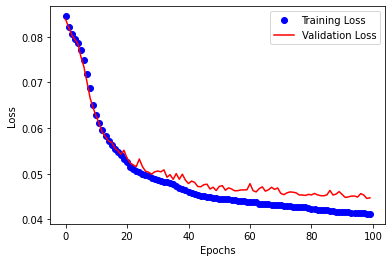

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 2.3. Visualize the reconstructed test images

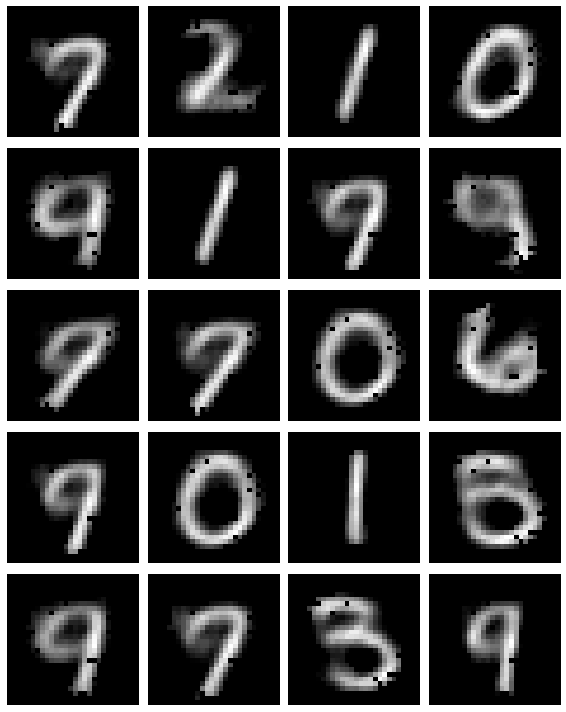

In [9]:
ae_output = ae.predict(x_test).reshape((10000, 28, 28))

ROW = 5
COLUMN = 4

x = ae_output
fname = 'reconstruct_ae.pdf'

fig, axes = plt.subplots(nrows=ROW, ncols=COLUMN, figsize=(8, 10))
for ax, i in zip(axes.flat, numpy.arange(ROW*COLUMN)):
    image = x[i].reshape(28, 28)
    ax.imshow(image, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.savefig(fname)
plt.show()

### 2.4. Evaluate the model on the test set

Do NOT used the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [10]:
loss = ae.evaluate(x_test, x_test)
print('loss = ' + str(loss))

313/313 [==============================] - 0s 610us/step - loss: 0.0447
loss = 0.044694237411022186


### 2.5. Visualize the low-dimensional features

In [11]:
# build the encoder network
ae_encoder = models.Model(input_img, bottleneck)
ae_encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 784)]             0         
_________________________________________________________________
encode1 (Dense)              (None, 128)               100480    
_________________________________________________________________
encode2 (Dense)              (None, 32)                4128      
_________________________________________________________________
encode3 (Dense)              (None, 8)                 264       
_________________________________________________________________
bottleneck (Dense)           (None, 2)                 18        
Total params: 104,890
Trainable params: 104,890
Non-trainable params: 0
_________________________________________________________________


In [12]:
# extract low-dimensional features from the test data
encoded_test = ae_encoder.predict(x_test)
print('Shape of encoded_test: ' + str(encoded_test.shape))

Shape of encoded_test: (10000, 2)


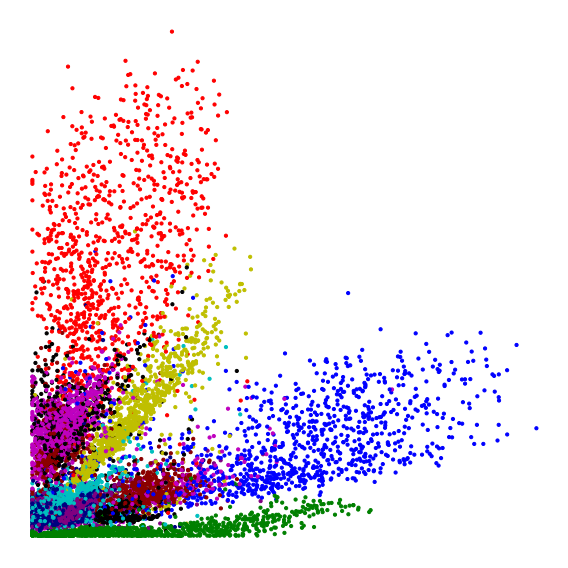

In [13]:
colors = numpy.array(['r', 'g', 'b', 'm', 'c', 'k', 'y', 'purple', 'darkred', 'navy'])
colors_test = colors[y_test]


import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8, 8))
plt.scatter(encoded_test[:, 0], encoded_test[:, 1], s=10, c=colors_test, edgecolors=colors_test)
plt.axis('off')
plt.tight_layout()
fname = 'ae_code.pdf'
plt.savefig(fname)

#### Remark:

Judging from the visualization, the low-dim features seems not discriminative, as 2D features from different classes are mixed. Let quantatively find out whether they are discriminative.

## 3. Are the learned low-dim features discriminative?

To find the answer, lets train a classifier on the training set (the extracted 2-dim features) and evaluation on the test set.

In [14]:
# extract the 2D features from the training, validation, and test samples
f_tr = ae_encoder.predict(x_tr)
f_val = ae_encoder.predict(x_val)
f_te = ae_encoder.predict(x_test)

print('Shape of f_tr: ' + str(f_tr.shape))
print('Shape of f_te: ' + str(f_te.shape))

Shape of f_tr: (10000, 2)
Shape of f_te: (10000, 2)


In [15]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import models

input_feat = Input(shape=(2,))

hidden1 = Dense(128, activation='relu')(input_feat)
hidden2 = Dense(128, activation='relu')(hidden1)
output = Dense(10, activation='softmax')(hidden2)

classifier = models.Model(input_feat, output)

classifier.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 128)               384       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 18,186
Trainable params: 18,186
Non-trainable params: 0
_________________________________________________________________


In [16]:
classifier.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.RMSprop(lr=1E-4),
                  metrics=['acc'])

history = classifier.fit(f_tr, y_tr, 
                        batch_size=32, 
                        epochs=30, 
                        validation_data=(f_val, y_val))

Epoch 1/30
313/313 [==============================] - 1s 1ms/step - loss: 2.1641 - acc: 0.1816 - val_loss: 1.8084 - val_acc: 0.3691
Epoch 2/30
313/313 [==============================] - 0s 1ms/step - loss: 1.7566 - acc: 0.3712 - val_loss: 1.6580 - val_acc: 0.3816
Epoch 3/30
313/313 [==============================] - 0s 1ms/step - loss: 1.6239 - acc: 0.3891 - val_loss: 1.5566 - val_acc: 0.4252
Epoch 4/30
313/313 [==============================] - 0s 1ms/step - loss: 1.5221 - acc: 0.4390 - val_loss: 1.4649 - val_acc: 0.4886
Epoch 5/30
313/313 [==============================] - 0s 1ms/step - loss: 1.4349 - acc: 0.5102 - val_loss: 1.3816 - val_acc: 0.5316
Epoch 6/30
313/313 [==============================] - 0s 1ms/step - loss: 1.3575 - acc: 0.5526 - val_loss: 1.3032 - val_acc: 0.5667
Epoch 7/30
313/313 [==============================] - 0s 1ms/step - loss: 1.2610 - acc: 0.5971 - val_loss: 1.2421 - val_acc: 0.6063
Epoch 8/30
313/313 [==============================] - 0s 1ms/step - loss: 1.

### Conclusion

Using the 2D features, the validation accuracy is 60~70%. Recall that using the original data, the accuracy is about 98%. Obviously, the 2D features are not very discriminative.

We are going to build a supervised autoencode model for learning low-dimensional discriminative features.

## 4. Build a supervised autoencoder model


**You are required to build and train a supervised autoencoder look like the following.** (Not necessary the same.) You are required to add other layers properly to alleviate overfitting.


![Network Structure](https://github.com/wangshusen/CS583A-2019Spring/blob/master/homework/HM5/supervised_ae.png?raw=true "NetworkStructure")


### 4.1. Build the network

In [17]:
# build the supervised autoencoder network
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout, Activation
from tensorflow.keras import models
from tensorflow.keras import regularizers

input_img = Input(shape=(784,), name='input_img')

# encoder network
dropout1 = Dropout(0.6)(input_img)
encoder1 = Dense(512, name='encoder1')(dropout1)
batchnorm1 = BatchNormalization()(encoder1)
activation1 = Activation('relu')(batchnorm1)
encoder2 = Dense(128, name='encoder2')(activation1)
batchnorm2 = BatchNormalization()(encoder2)
activation2 = Activation('relu')(batchnorm2)
encoder3 = Dense(32, activation='relu', name='encoder3')(activation2)
encoder4 = Dense(8, activation='relu', name='encoder4')(encoder3)
# The width of the bottleneck layer must be exactly 2.
bottleneck = Dense(2, activation='relu', name='bottleneck')(encoder4)

# decoder network
decoder1 = Dense(8, activation='relu', name='decoder1')(bottleneck)
decoder2 = Dense(32, activation='relu', name='decoder2')(decoder1)
dropout2 = Dropout(0.3)(decoder2)
decoder3 = Dense(128, name='decoder3')(dropout2)
batchnorm2 = BatchNormalization()(decoder3)
activation2 = Activation('relu')(batchnorm2)
dropout3 = Dropout(0.3)(activation2)
decoder4 = Dense(246, activation='relu', kernel_regularizer=regularizers.l1_l2(0.01), name='decoder4')(dropout3)
dropout4 = Dropout(0.6)(activation2)
decoder5 = Dense(784, activation='relu', kernel_regularizer=regularizers.l1_l2(0.01), name='decoder5')(dropout4)

# build a classifier upon the bottleneck layer
classifier1 = Dense(32, activation='relu', name='classifier1')(bottleneck)
classifier2 = Dense(128, activation='relu', bias_regularizer=regularizers.l1_l2(0.01), name='classifier2')(classifier1)
dropout3 = Dropout(0.4)(classifier2)
classifier3 = Dense(256, kernel_regularizer=regularizers.l1_l2(0.01), name='classifier3')(dropout3)
batchnorm3 = BatchNormalization()(classifier3)
activation3 = Activation('relu')(batchnorm3)
classifier4 = Dense(10, activation='softmax', name='classifier4')(activation3)

In [18]:
# connect the input and the two outputs
sae = models.Model(input_img, [decoder5, classifier4])

sae.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 784)]        0                                            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 784)          0           input_img[0][0]                  
__________________________________________________________________________________________________
encoder1 (Dense)                (None, 512)          401920      dropout[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512)          2048        encoder1[0][0]                   
____________________________________________________________________________________________

In [19]:
# print the network structure to a PDF file

from IPython.display import SVG
from tensorflow.keras.utils import plot_model, model_to_dot

SVG(model_to_dot(sae, show_shapes=False).create(prog='dot', format='svg'))

plot_model(
    model=sae, show_shapes=False,
    to_file='supervised_ae.pdf'
)

# you can find the file "supervised_ae.pdf" in the current directory.

### 4.2. Train the new model and tune the hyper-parameters

The new model has multiple output. Thus we specify **multiple** loss functions and their weights. 

In [20]:
from tensorflow.keras import optimizers

sae.compile(loss=['mean_squared_error', 'categorical_crossentropy'],
            loss_weights=[1.8, 0.5], # to be tuned
            optimizer=optimizers.RMSprop(lr=2E-3))

history = sae.fit(x_tr, [x_tr, y_tr], 
                  batch_size=64, 
                  epochs=50, 
                  validation_data=(x_val, [x_val, y_val]))

Epoch 1/50
157/157 [==============================] - 4s 12ms/step - loss: 16.7215 - decoder5_loss: 0.1007 - classifier4_loss: 2.0053 - val_loss: 2.6126 - val_decoder5_loss: 0.0698 - val_classifier4_loss: 2.0754
Epoch 2/50
157/157 [==============================] - 2s 10ms/step - loss: 2.3427 - decoder5_loss: 0.0685 - classifier4_loss: 1.6444 - val_loss: 2.4508 - val_decoder5_loss: 0.0668 - val_classifier4_loss: 1.8573
Epoch 3/50
157/157 [==============================] - 1s 10ms/step - loss: 2.2903 - decoder5_loss: 0.0669 - classifier4_loss: 1.5583 - val_loss: 2.3371 - val_decoder5_loss: 0.0670 - val_classifier4_loss: 1.5327
Epoch 4/50
157/157 [==============================] - 1s 9ms/step - loss: 2.2299 - decoder5_loss: 0.0670 - classifier4_loss: 1.3759 - val_loss: 2.1872 - val_decoder5_loss: 0.0668 - val_classifier4_loss: 1.2443
Epoch 5/50
157/157 [==============================] - 1s 9ms/step - loss: 2.1422 - decoder5_loss: 0.0670 - classifier4_loss: 1.2022 - val_loss: 2.1076 - val

Epoch 40/50
157/157 [==============================] - 3s 19ms/step - loss: 1.7230 - decoder5_loss: 0.0662 - classifier4_loss: 0.4144 - val_loss: 1.7403 - val_decoder5_loss: 0.0653 - val_classifier4_loss: 0.4447
Epoch 41/50
157/157 [==============================] - 3s 19ms/step - loss: 1.7213 - decoder5_loss: 0.0662 - classifier4_loss: 0.4203 - val_loss: 1.7188 - val_decoder5_loss: 0.0664 - val_classifier4_loss: 0.3795
Epoch 42/50
157/157 [==============================] - 3s 19ms/step - loss: 1.7157 - decoder5_loss: 0.0665 - classifier4_loss: 0.4073 - val_loss: 1.6840 - val_decoder5_loss: 0.0652 - val_classifier4_loss: 0.3088
Epoch 43/50
157/157 [==============================] - 3s 19ms/step - loss: 1.7347 - decoder5_loss: 0.0663 - classifier4_loss: 0.4477 - val_loss: 1.7657 - val_decoder5_loss: 0.0663 - val_classifier4_loss: 0.4778
Epoch 44/50
157/157 [==============================] - 3s 18ms/step - loss: 1.7246 - decoder5_loss: 0.0666 - classifier4_loss: 0.4256 - val_loss: 1.6590

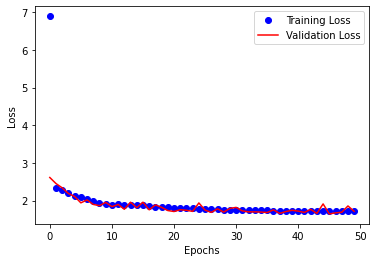

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Question

Do you think overfitting is happening? If yes, what can you do? Please make necessary changes to the supervised autoencoder network structure.

**Failing to add proper regularization will lose 1~2 scores.**

### 4.3. Visualize the reconstructed test images

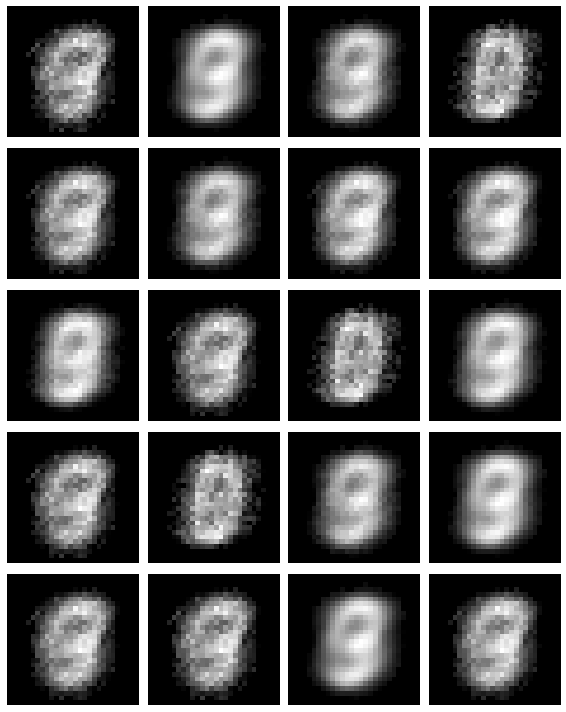

In [22]:
sae_output = sae.predict(x_test)[0].reshape((10000, 28, 28))

ROW = 5
COLUMN = 4

x = sae_output
fname = 'reconstruct_sae.pdf'

fig, axes = plt.subplots(nrows=ROW, ncols=COLUMN, figsize=(8, 10))
for ax, i in zip(axes.flat, numpy.arange(ROW*COLUMN)):
    image = x[i].reshape(28, 28)
    ax.imshow(image, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.savefig(fname)
plt.show()

### 4.4. Visualize the low-dimensional features

In [23]:
# build the encoder model
sae_encoder = models.Model(input_img, bottleneck)
sae_encoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 784)]             0         
_________________________________________________________________
dropout (Dropout)            (None, 784)               0         
_________________________________________________________________
encoder1 (Dense)             (None, 512)               401920    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
encoder2 (Dense)             (None, 128)               65664     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512 

Shape of encoded_test: (10000, 2)


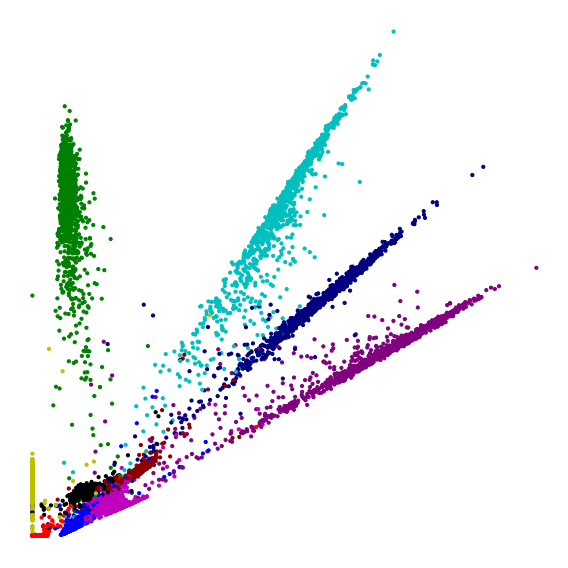

In [24]:
# extract test features
encoded_test = sae_encoder.predict(x_test)
print('Shape of encoded_test: ' + str(encoded_test.shape))

colors = numpy.array(['r', 'g', 'b', 'm', 'c', 'k', 'y', 'purple', 'darkred', 'navy'])
colors_test = colors[y_test]


import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8, 8))
plt.scatter(encoded_test[:, 0], encoded_test[:, 1], s=10, c=colors_test, edgecolors=colors_test)
plt.axis('off')
plt.tight_layout()
fname = 'sae_code.pdf'
plt.savefig(fname)

### 4.5. Are the learned low-dim features discriminative?

To find the answer, lets train a classifier on the training set (the extracted 2-dim features) and evaluation on the validation and test set.


In [25]:
# extract 2D features from the training, validation, and test samples
f_tr = sae_encoder.predict(x_tr)
f_val = sae_encoder.predict(x_val)
f_te = sae_encoder.predict(x_test)

In [26]:
# build a classifier which takes the 2D features as input
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import models

input_feat = Input(shape=(2,))

hidden1 = Dense(128, activation='relu')(input_feat)
hidden2 = Dense(128, activation='relu')(hidden1)
output = Dense(10, activation='softmax')(hidden2)

classifier = models.Model(input_feat, output)

classifier.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               384       
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1290      
Total params: 18,186
Trainable params: 18,186
Non-trainable params: 0
_________________________________________________________________


In [27]:
classifier.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.RMSprop(lr=1E-4),
                  metrics=['acc'])

history = classifier.fit(f_tr, y_tr, 
                        batch_size=32, 
                        epochs=30, 
                        validation_data=(f_val, y_val))

Epoch 1/30
313/313 [==============================] - 1s 2ms/step - loss: 1.9037 - acc: 0.2904 - val_loss: 1.4354 - val_acc: 0.4013
Epoch 2/30
313/313 [==============================] - 0s 1ms/step - loss: 1.3013 - acc: 0.4433 - val_loss: 1.0819 - val_acc: 0.7273
Epoch 3/30
313/313 [==============================] - 0s 1ms/step - loss: 0.9391 - acc: 0.7960 - val_loss: 0.7888 - val_acc: 0.9375
Epoch 4/30
313/313 [==============================] - 0s 1ms/step - loss: 0.6461 - acc: 0.9632 - val_loss: 0.5504 - val_acc: 0.9481
Epoch 5/30
313/313 [==============================] - 0s 1ms/step - loss: 0.4123 - acc: 0.9791 - val_loss: 0.4005 - val_acc: 0.9486
Epoch 6/30
313/313 [==============================] - 0s 1ms/step - loss: 0.2573 - acc: 0.9798 - val_loss: 0.3327 - val_acc: 0.9473
Epoch 7/30
313/313 [==============================] - 0s 1ms/step - loss: 0.1786 - acc: 0.9788 - val_loss: 0.3074 - val_acc: 0.9465
Epoch 8/30
313/313 [==============================] - 0s 1ms/step - loss: 0.

#### Remark:

The validation accuracy must be above 90%. It means the low-dim features learned by the supervised autoencoder are very effective.

In [28]:
from sklearn.metrics import accuracy_score
# evaluate your model on the never-seen-before test data
# write your code here:
prediction = classifier.predict(f_te)
accuracy_score(numpy.argmax(prediction, axis=1), y_test)

0.9566